In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# 1. Загрузка данных
data_path = '/kaggle/input/spotify/dataset (2).csv'
data = pd.read_csv(data_path)
'''

'''

'\n\n'

Получение основной информации из датасета, а также проводим проверку и замену пустых данных для избежания ошибок. Также создаем целевую переменную и разделяем признаки


In [2]:
print(data.head())

print(data.info())
target_column = 'popularity'
y = data[target_column]
X = data.drop(columns=[target_column])
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
X.fillna(X.median(numeric_only=True), inplace=True)

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


Исследовательский анализ данных (EDA)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


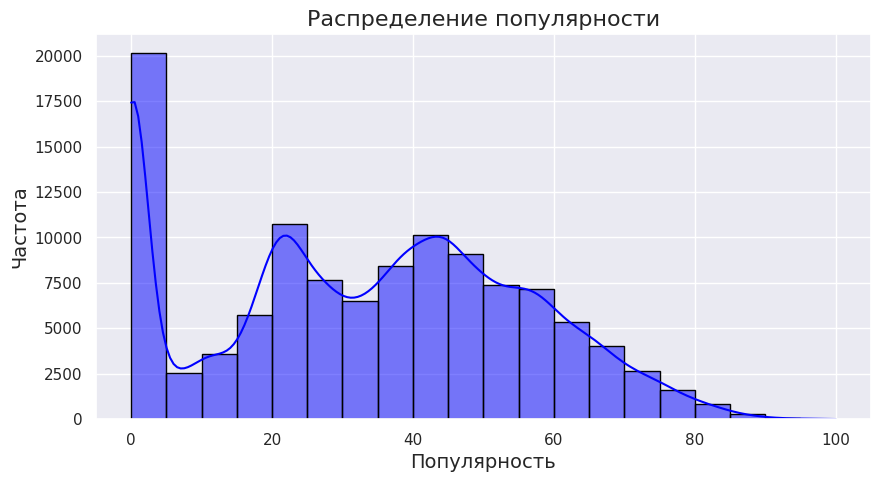

In [3]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 5))
sns.histplot(y, bins=20, kde=True, color='blue', edgecolor='black')
plt.title("Распределение популярности", fontsize=16)
plt.xlabel("Популярность", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.show()

Здесь мы смотрим распределение популярных треков

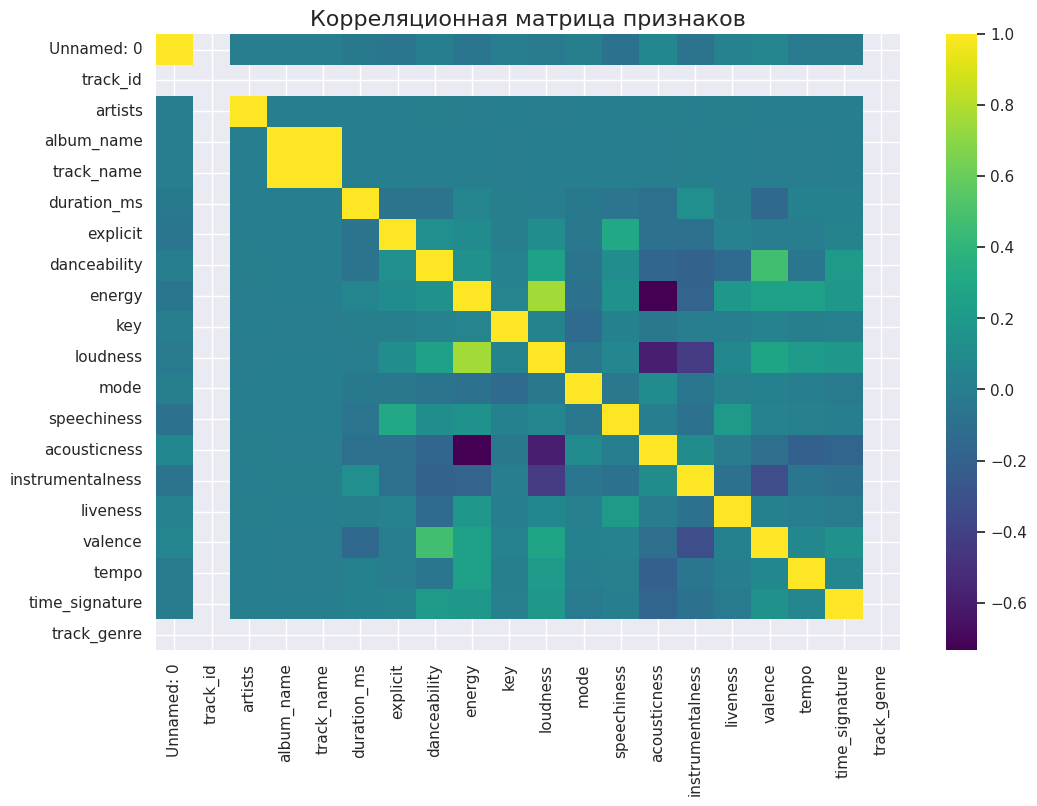

In [4]:
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Корреляционная матрица признаков', fontsize=16)
plt.show()

Здесь мы смотрим корреляционную матрицу признаков, и какие признаки влияют на популярность. Исходя из анализа матрицы, можно понять, что на популярность треков могут влиять танцевальность, энергичность, громкость, жанр и темп.  

Колонка: Unnamed: 0
Количество выбросов: 0 (0.00%)
Границы: [-56999.50, 170998.50]



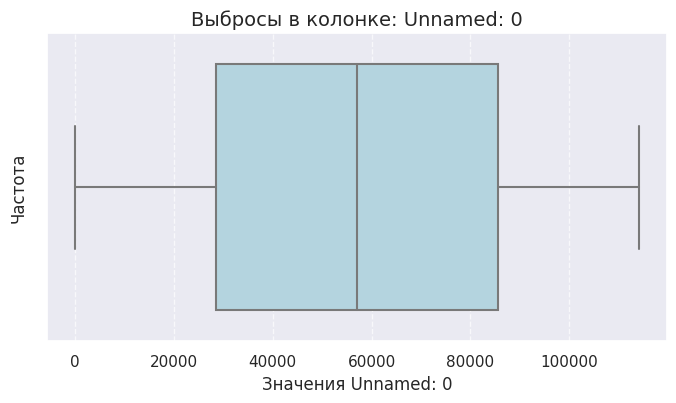

Колонка: track_id
Количество выбросов: 0 (0.00%)
Границы: [nan, nan]



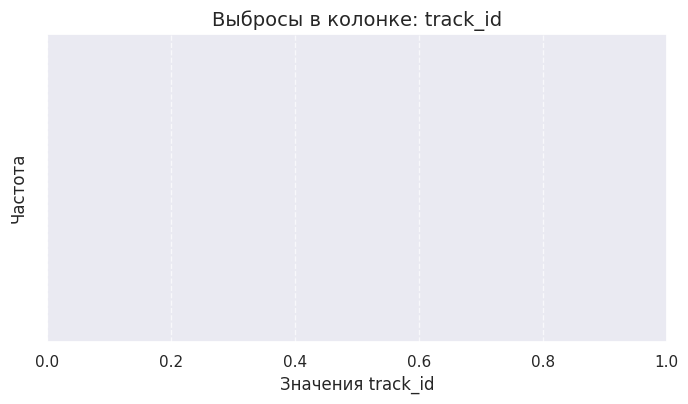

Колонка: artists
Количество выбросов: 44 (0.04%)
Границы: [1995.00, 1995.00]



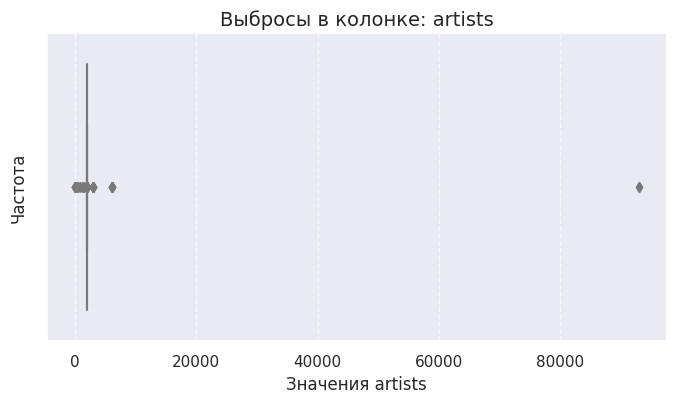

Колонка: album_name
Количество выбросов: 285 (0.25%)
Границы: [25.00, 25.00]



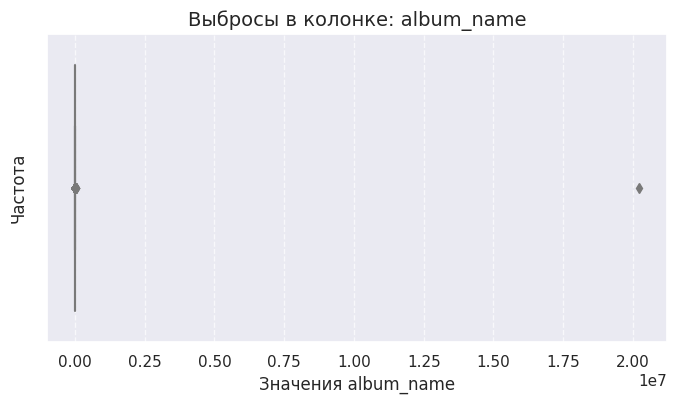

Колонка: track_name
Количество выбросов: 168 (0.15%)
Границы: [679.00, 679.00]



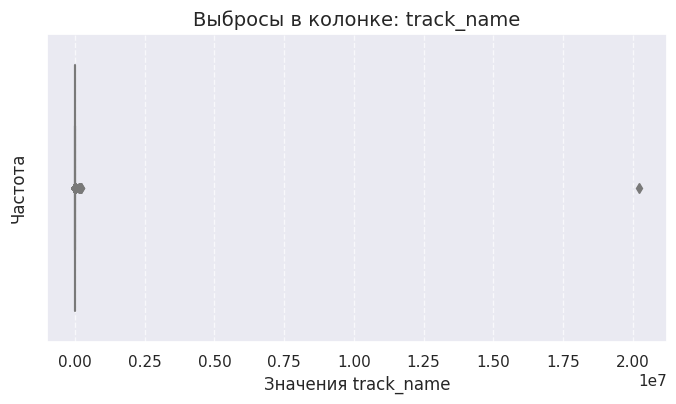

Колонка: duration_ms
Количество выбросов: 5617 (4.93%)
Границы: [42906.00, 392666.00]



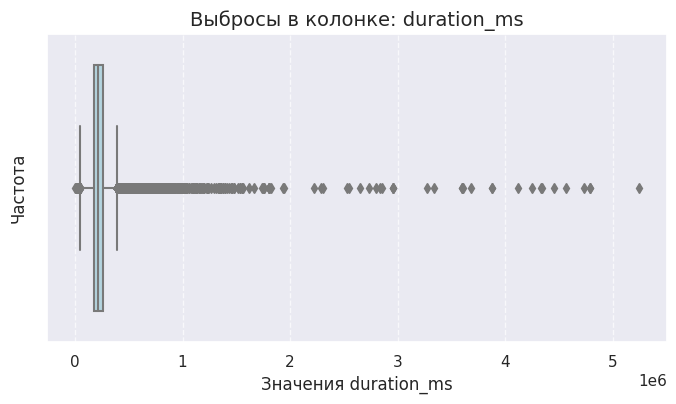

Колонка: danceability
Количество выбросов: 620 (0.54%)
Границы: [0.10, 1.05]



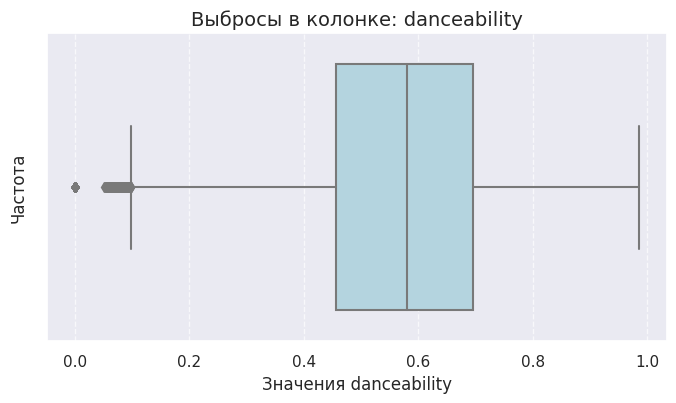

Колонка: energy
Количество выбросов: 0 (0.00%)
Границы: [-0.10, 1.43]



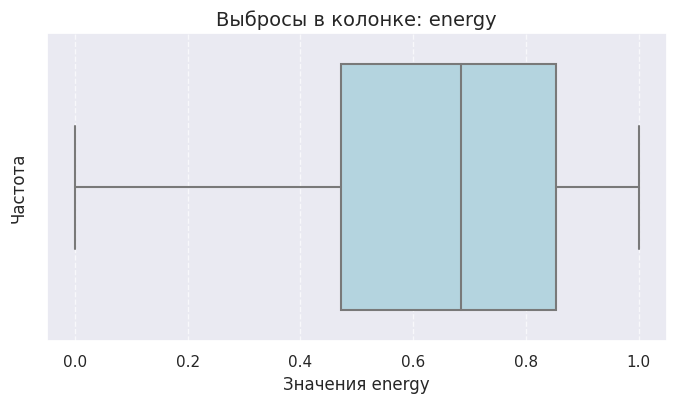

Колонка: key
Количество выбросов: 0 (0.00%)
Границы: [-7.00, 17.00]



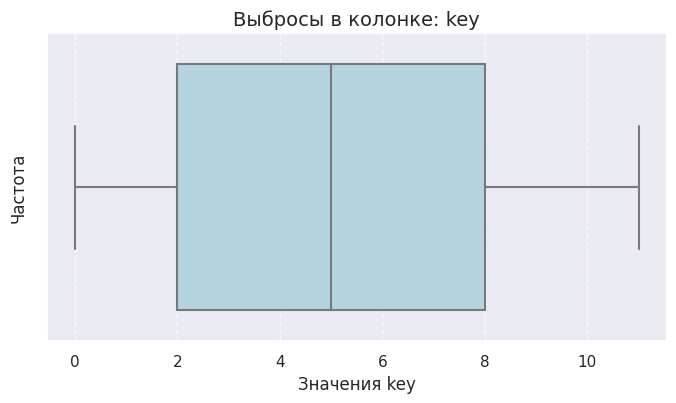

Колонка: loudness
Количество выбросов: 6173 (5.41%)
Границы: [-17.53, 2.51]



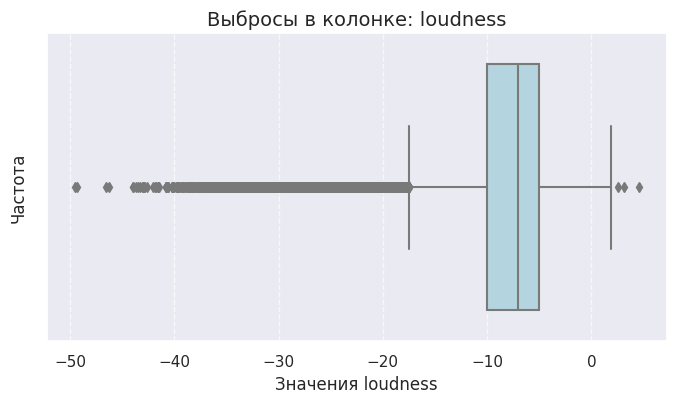

Колонка: mode
Количество выбросов: 0 (0.00%)
Границы: [-1.50, 2.50]



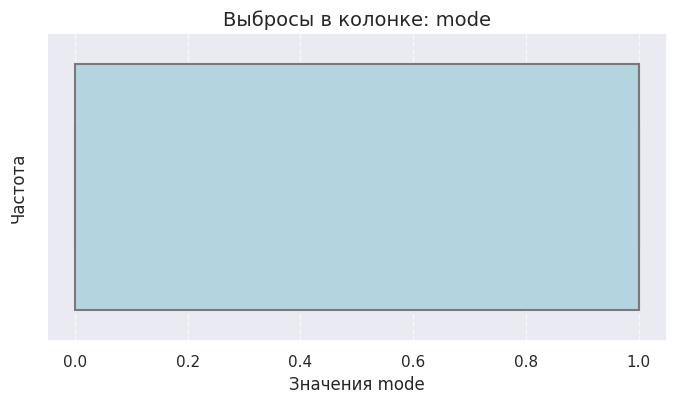

Колонка: speechiness
Количество выбросов: 13211 (11.59%)
Границы: [-0.04, 0.16]



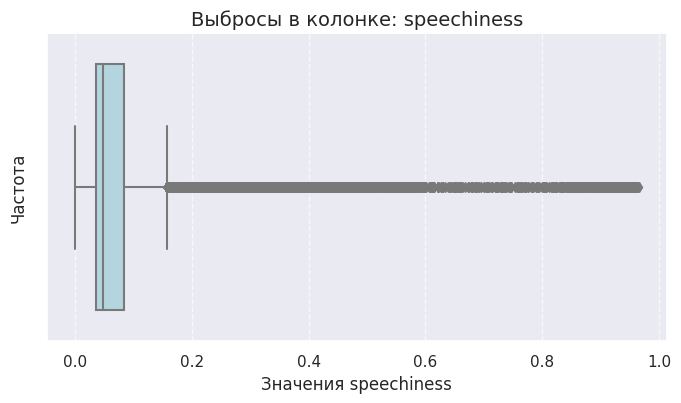

Колонка: acousticness
Количество выбросов: 0 (0.00%)
Границы: [-0.85, 1.47]



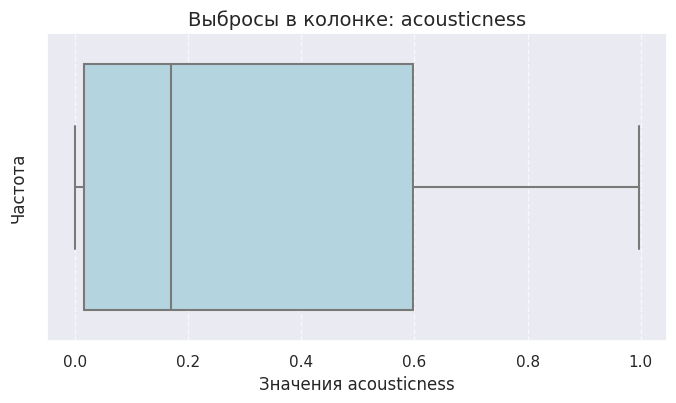

Колонка: instrumentalness
Количество выбросов: 25246 (22.15%)
Границы: [-0.07, 0.12]



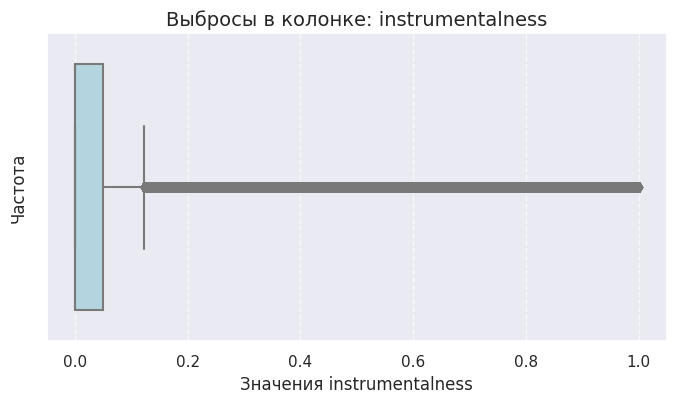

Колонка: liveness
Количество выбросов: 8642 (7.58%)
Границы: [-0.16, 0.54]



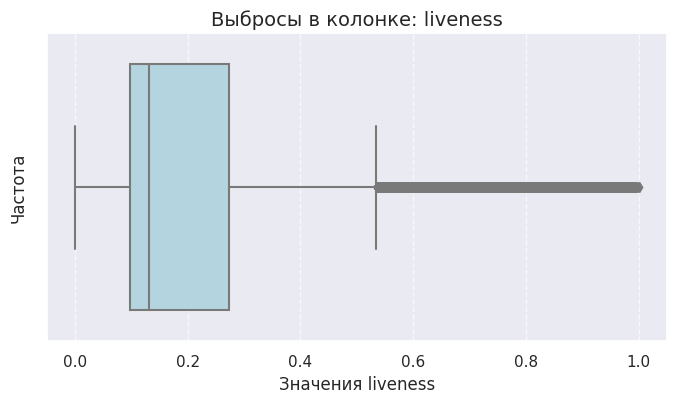

Колонка: valence
Количество выбросов: 0 (0.00%)
Границы: [-0.37, 1.32]



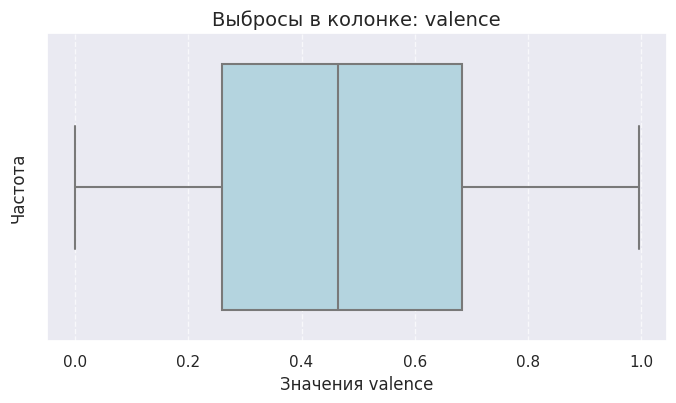

Колонка: tempo
Количество выбросов: 617 (0.54%)
Границы: [37.94, 201.35]



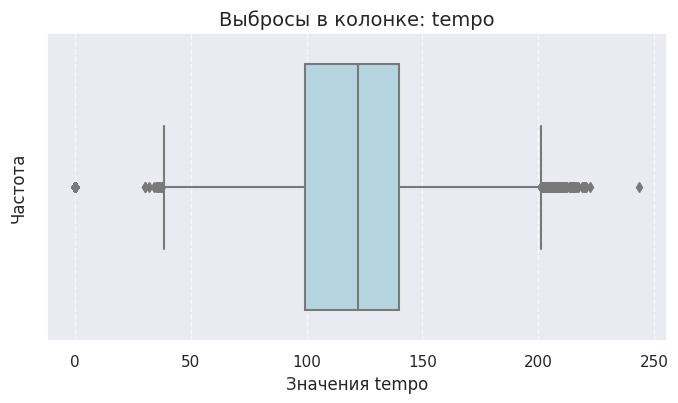

Колонка: time_signature
Количество выбросов: 12157 (10.66%)
Границы: [4.00, 4.00]



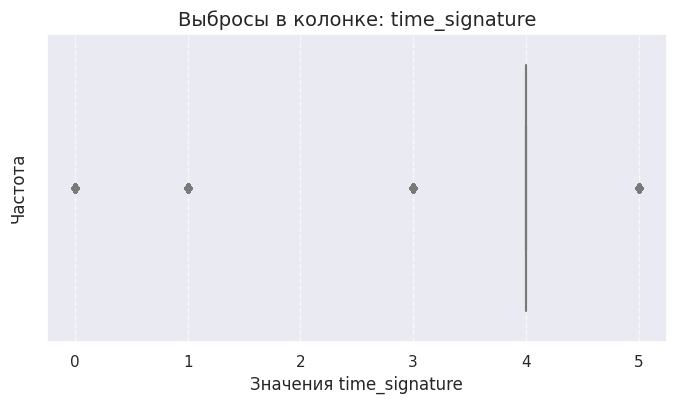

Колонка: track_genre
Количество выбросов: 0 (0.00%)
Границы: [nan, nan]



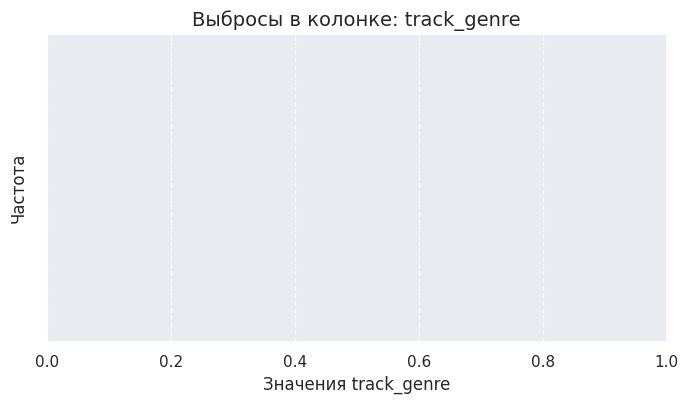

In [5]:
# 2.3 Анализ выбросов
for col in X.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=X[col], color='lightblue')
    plt.title(f'Выбросы в колонке: {col}', fontsize=14)
    plt.xlabel(f'Значения {col}', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Вывод статистики о выбросах
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)][col]
    
    print(f"Колонка: {col}")
    print(f"Количество выбросов: {len(outliers)} ({len(outliers) / len(X) * 100:.2f}%)")
    print(f"Границы: [{lower_bound:.2f}, {upper_bound:.2f}]\n")
    plt.show()



Добавлен новый бинарный признак: is_explicit
Все данные успешно обработаны.
Важность признаков:
Unnamed: 0          1.824693
duration_ms         0.446084
tempo               0.444465
loudness            0.387445
acousticness        0.298347
instrumentalness    0.253128
valence             0.193452
energy              0.192709
speechiness         0.178654
liveness            0.167808
danceability        0.160843
key                 0.013290
time_signature      0.006665
explicit            0.006201
is_explicit         0.005744
mode                0.003011
track_id            0.002212
artists             0.001117
track_name          0.000880
album_name          0.000652
track_genre         0.000000
dtype: float64


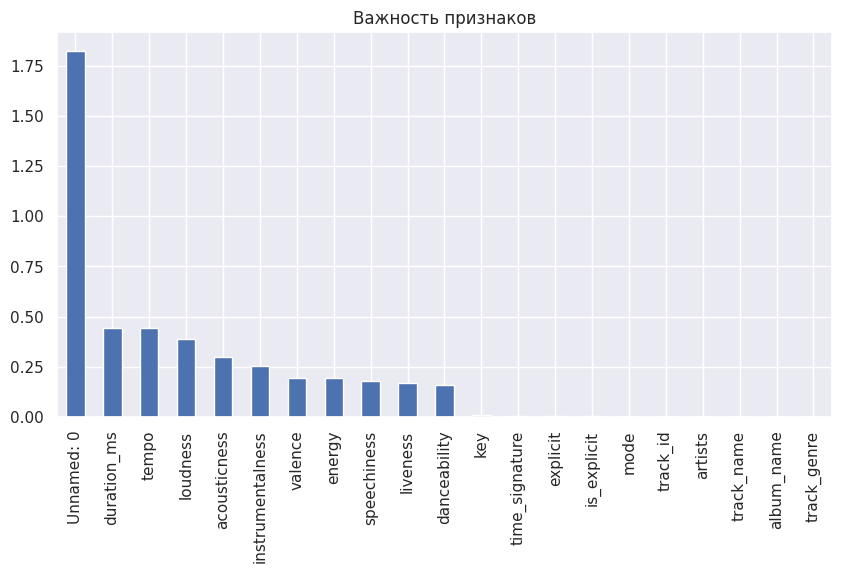

In [6]:
# 3. Feature Engineering
# Создание нового признака на основе explicit-контента
if 'explicit' in X.columns:
    X['is_explicit'] = X['explicit'].astype(float).fillna(0).astype(int)  # Преобразование True/False в 1/0 и заполнение NaN
    print("Добавлен новый бинарный признак: is_explicit")
else:
    print("Колонка 'explicit' отсутствует в данных")

# Повторная проверка и обработка пропусков после создания нового признака
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
X.fillna(0, inplace=True)

# Удаление или замена значений infinity и слишком больших чисел
X.replace([np.inf, -np.inf], 0, inplace=True)  # Заменяем infinity на 0
X = X.clip(lower=-1e10, upper=1e10)  # Ограничиваем значения в разумных пределах

# Проверка на наличие оставшихся проблемных значений
if X.isna().sum().sum() > 0 or not np.isfinite(X).all().all():
    print("Предупреждение: Данные всё ещё содержат недопустимые значения!")
else:
    print("Все данные успешно обработаны.")

# 3.1 Оценка важности признаков
feature_scores = pd.Series(mutual_info_classif(X, y, discrete_features=False), index=X.columns)
print("Важность признаков:")
print(feature_scores.sort_values(ascending=False))
import matplotlib.pyplot as plt

feature_scores.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title('Важность признаков')
plt.show()


Здесь была самая сложная работа. При создании нового признака, создавалось много пропусков, а при попытке исправить их, появлялись бесконечные значения

In [7]:
# 4. Построение моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 4.1 Логистическая регрессия
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
print("Отчёт по логистической регрессии:")
print(classification_report(y_test, y_pred_log))

# 4.2 Случайный лес
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Отчёт по случайному лесу:")
print(classification_report(y_test, y_pred_rf))

# 4.3 XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("Отчёт по XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# 4.4 Нейронная сеть
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print("Отчёт по MLP:")
print(classification_report(y_test, y_pred_mlp))


Отчёт по логистической регрессии:
              precision    recall  f1-score   support

           0       0.14      0.99      0.25      3214
           1       0.00      0.00      0.00       448
           2       0.00      0.00      0.00       209
           3       0.00      0.00      0.00       127
           4       0.00      0.00      0.00        76
           5       0.11      0.07      0.08       115
           6       0.00      0.00      0.00        80
           7       0.00      0.00      0.00        85
           8       0.10      0.01      0.02       111
           9       0.00      0.00      0.00       105
          10       0.05      0.01      0.02       135
          11       0.00      0.00      0.00       162
          12       0.00      0.00      0.00       171
          13       0.00      0.00      0.00       141
          14       0.00      0.00      0.00       117
          15       0.00      0.00      0.00       132
          16       0.11      0.00      0.01    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Отчёт по случайному лесу:
              precision    recall  f1-score   support

           0       0.32      0.87      0.47      3214
           1       0.43      0.38      0.40       448
           2       0.34      0.25      0.29       209
           3       0.32      0.25      0.28       127
           4       0.30      0.21      0.25        76
           5       0.24      0.25      0.25       115
           6       0.22      0.14      0.17        80
           7       0.16      0.14      0.15        85
           8       0.36      0.33      0.35       111
           9       0.21      0.13      0.16       105
          10       0.23      0.24      0.24       135
          11       0.22      0.21      0.21       162
          12       0.26      0.22      0.24       171
          13       0.32      0.29      0.30       141
          14       0.28      0.14      0.18       117
          15       0.16      0.08      0.11       132
          16       0.30      0.25      0.27       211
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Отчёт по XGBoost:
              precision    recall  f1-score   support

           0       0.40      0.86      0.55      3214
           1       0.43      0.18      0.26       448
           2       0.37      0.19      0.25       209
           3       0.27      0.16      0.20       127
           4       0.46      0.22      0.30        76
           5       0.29      0.28      0.28       115
           6       0.23      0.19      0.21        80
           7       0.19      0.18      0.18        85
           8       0.30      0.33      0.32       111
           9       0.17      0.15      0.16       105
          10       0.23      0.27      0.25       135
          11       0.18      0.20      0.19       162
          12       0.18      0.20      0.19       171
          13       0.19      0.26      0.22       141
          14       0.17      0.15      0.16       117
          15       0.15      0.11      0.12       132
          16       0.30      0.30      0.30       211
         

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_

Отчёт по MLP:
              precision    recall  f1-score   support

           0       0.19      0.93      0.31      3214
           1       0.00      0.00      0.00       448
           2       0.00      0.00      0.00       209
           3       0.00      0.00      0.00       127
           4       0.00      0.00      0.00        76
           5       0.10      0.09      0.09       115
           6       0.05      0.06      0.06        80
           7       0.09      0.06      0.07        85
           8       0.10      0.06      0.08       111
           9       0.19      0.07      0.10       105
          10       0.06      0.07      0.07       135
          11       0.10      0.12      0.11       162
          12       0.16      0.16      0.16       171
          13       0.15      0.16      0.15       141
          14       0.08      0.02      0.03       117
          15       0.00      0.00      0.00       132
          16       0.11      0.06      0.07       211
          17 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [10]:
'''# 5. Кросс-валидация
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='accuracy')
print("Средняя точность модели XGBoost на кросс-валидации:", np.mean(xgb_scores))
# Проверка целевой переменной
print("Распределение классов в целевой переменной:")
print(y.value_counts())

# Обработка данных
X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

# Обновление модели с учетом дисбаланса
xgb_model = XGBClassifier(eval_metric='mlogloss', scale_pos_weight=len(y[y == 0]) / len(y[y == 1]), random_state=42)

# StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Кросс-валидация
xgb_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='accuracy')
print("Средняя точность модели XGBoost на кросс-валидации:", np.mean(xgb_scores))
'''
# 5. Кросс-валидация
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = []

for train_index, test_index in kf.split(X, y):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Обучение модели на текущем разбиении
    xgb_model.fit(X_train_kf, y_train_kf)
    y_pred_kf = xgb_model.predict(X_test_kf)

    # Оценка точности
    score = accuracy_score(y_test_kf, y_pred_kf)
    xgb_scores.append(score)

print("Средняя точность модели XGBoost на кросс-валидации:", np.mean(xgb_scores))

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:23:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:24:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:25:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.



KeyboardInterrupt: 